# Importing the Libraries and Data

In [1]:
import os 
import time 
import csv
from tqdm import tqdm
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
IMAGE_SIZE = 224

TRAIN_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

TEST_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=TRAIN_TFMS)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=TEST_TFMS)

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')

100%|██████████| 170498071/170498071 [00:04<00:00, 37037155.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


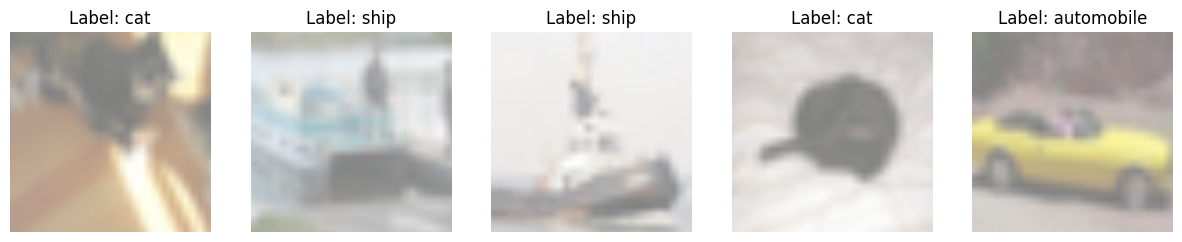

In [3]:
torch.manual_seed(42)

def denormalize(img_tensor):
    # Undo normalization: img = img * std + mean
    img = img_tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img

# CIFAR-10 classes
classes = testset.classes

# Select 5 random images from the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=True)
dataiter = iter(testloader)
images, labels = next(dataiter)

# Create a plot for the 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    img = denormalize(images[i])  # Remove normalization
    img = img.permute(1, 2, 0)    # Convert from CHW to HWC for displaying
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {classes[labels[i]]}')
    axes[i].axis('off')

plt.show()

# Finetuning the Resnet-34 Model

### Loading the Model

In [4]:
torch.manual_seed(42)

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


### Training & Evaluation Functions

In [5]:
def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

In [6]:
torch.manual_seed(42)

out_dir = 'base-model'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 32
lr = 3e-4
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Finetuning {num_params*1e-6:.3f}M params on {device} for {epochs} epochs ...')

os.makedirs(out_dir+'/log', exist_ok = True)
bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'

with open(os.path.join(out_dir, 'log/run.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  # Track the start time of the epoch

        train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
        test_loss, test_acc = eval_step(model, test_dl, criterion, device)

        writer.writerow([epoch + 1, train_loss, train_acc, test_loss, test_acc])

        # Calculate epoch duration
        epoch_duration = time.time() - start_time

        # Use tqdm.write to print epoch summary with duration
        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Test Acc: {test_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")

Finetuning 0.005M params on cuda for 5 epochs ...


Epochs:   0%|           | Epoch: 0/5 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.0669 Acc: 0.6700
Evaluation: [312/313] Loss: 0.7456 Acc: 0.7579

Epochs:  20%|██         | Epoch: 1/5 | Time: 02:02 < 08:10 | 122.68s/it

Evaluation: [313/313] Loss: 0.7456 Acc: 0.7579
============ Epoch 1 --> Train Acc: 0.6700 || Test Acc: 0.7579 || Time: 122.68 s ============

Training: [1563/1563] Loss: 0.7333 Acc: 0.7562
Evaluation: [312/313] Loss: 0.6746 Acc: 0.7717

Epochs:  40%|████       | Epoch: 2/5 | Time: 04:03 < 06:05 | 121.76s/it

Evaluation: [313/313] Loss: 0.6747 Acc: 0.7721
============ Epoch 2 --> Train Acc: 0.7562 || Test Acc: 0.7721 || Time: 121.11 s ============

Training: [1563/1563] Loss: 0.6830 Acc: 0.7685
Evaluation: [309/313] Loss: 0.6569 Acc: 0.7746

Epochs:  60%|██████     | Epoch: 3/5 | Time: 06:04 < 04:02 | 121.40s/it

Evaluation: [313/313] Loss: 0.6573 Acc: 0.7748
============ Epoch 3 --> Train Acc: 0.7685 || Test Acc: 0.7748 || Time: 120.98 s ============

Training: [1563/1563] Loss: 0.6601 Acc: 0.7759
Evaluation: [311/313] Loss: 0.6335 Acc: 0.7811

Epochs:  80%|████████   | Epoch: 4/5 | Time: 08:05 < 02:01 | 121.32s/it

Evaluation: [313/313] Loss: 0.6338 Acc: 0.7815
============ Epoch 4 --> Train Acc: 0.7759 || Test Acc: 0.7815 || Time: 121.18 s ============

Training: [1563/1563] Loss: 0.6460 Acc: 0.7792
Evaluation: [309/313] Loss: 0.6289 Acc: 0.7828

Epochs: 100%|██████████ | Epoch: 5/5 | Time: 10:07 < 00:00 | 121.43s/it

Evaluation: [313/313] Loss: 0.6294 Acc: 0.7829
============ Epoch 5 --> Train Acc: 0.7792 || Test Acc: 0.7829 || Time: 121.19 s ============



# Localised Noise Injection (Part 1)

### Creating the Transform

In [7]:
class AddNoiseToPatch:
    def __init__(self, noise_level=0.1, patch_coords=(0, 0, 50, 50)):
        self.noise_level = noise_level
        self.patch_coords = patch_coords  # (x1, y1, x2, y2)

    def __call__(self, img):
        # Convert to numpy array
        img_np = np.array(img)

        # Extract patch coordinates
        x1, y1, x2, y2 = self.patch_coords
        
        # Generate random noise
        noise = np.random.normal(0, self.noise_level, img_np[y1:y2, x1:x2].shape).astype(np.uint8)

        # Add noise to the patch
        img_np[y1:y2, x1:x2] = np.clip(img_np[y1:y2, x1:x2] + noise, 0, 255)

        # Convert back to PIL Image
        return Image.fromarray(img_np)

NOISE_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    AddNoiseToPatch(noise_level=25, patch_coords=(90, 90, 150, 150)),
    transforms.ToTensor(),
])    

### Evaluation

In [8]:
torch.manual_seed(42)

noise_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=NOISE_TFMS)
noise_test_dl = torch.utils.data.DataLoader(noise_testset, batch_size=batch_size, shuffle=False)

normal_loss, normal_acc = eval_step(model, test_dl, criterion, device)
noise_loss, noise_acc = eval_step(model, noise_test_dl, criterion, device)

print(f'\n======================== Noise  Accuracy: {noise_acc*100:.3f}% ========================')
print(f'======================== Normal Accuracy: {normal_acc*100:.3f}% ========================')

Files already downloaded and verified
Evaluation: [313/313] Loss: 0.6294 Acc: 0.7829
Evaluation: [313/313] Loss: 1.5645 Acc: 0.4908

======================== Noise  Accuracy: 49.081% ========================
======================== Normal Accuracy: 78.295% ========================


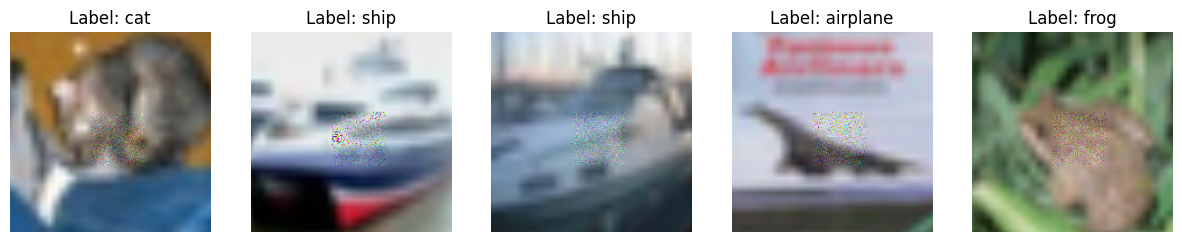

In [9]:
torch.manual_seed(42)

testloader = noise_test_dl
dataiter = iter(testloader)
images, labels = next(dataiter)

# Create a plot for the 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    img = images[i].permute(1, 2, 0)    # Convert from CHW to HWC for displaying
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {classes[labels[i]]}')
    axes[i].axis('off')

plt.savefig('./task5_noise.png')
plt.show()

# Patch Scrambling (Part 2)

### Scrambler Class

In [10]:
class PatchScrambler:
    def __init__(self, patch_size=16):
        self.patch_size = patch_size
    
    def scramble(self, image):
        c, h, w = image.shape
        
        # Checl if image is divisible by patch_size
        assert h % self.patch_size == 0 and w % self.patch_size == 0, "Image size must be divisible by patch size"
        
        num_patches_h = h // self.patch_size
        num_patches_w = w // self.patch_size
        
        # Split image into patches
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        
        # Reshape into (num_patches_h * num_patches_w, C, patch_size, patch_size)
        patches = patches.contiguous().view(c, -1, self.patch_size, self.patch_size)
        patches = patches.permute(1, 0, 2, 3)

        # Shuffle the patches
        permuted_indices = torch.randperm(patches.size(0))
        scrambled_patches = patches[permuted_indices]
        
        # Reshape back into original image form
        scrambled_image = scrambled_patches.permute(1, 0, 2, 3).contiguous().view(c, num_patches_h, num_patches_w, self.patch_size, self.patch_size)
        
        # Reassemble the image from scrambled patches
        scrambled_image = scrambled_image.permute(0, 1, 3, 2, 4).contiguous().view(c, h, w)
        
        return scrambled_image
    
    def __call__(self, image):
        return self.scramble(image)

SCRAMBLE_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    PatchScrambler(patch_size=56),
])  

### Evaluation

In [11]:
torch.manual_seed(42)

scramble_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=SCRAMBLE_TFMS)
scramble_test_dl = torch.utils.data.DataLoader(scramble_testset, batch_size=batch_size, shuffle=False)

scramble_loss, scramble_acc = eval_step(model, scramble_test_dl, criterion, device)

print(f'\n======================== Scramble  Accuracy: {scramble_acc*100:.3f}% ========================')
print(f'======================== Normal Accuracy: {normal_acc*100:.3f}% ========================')

Files already downloaded and verified
Evaluation: [313/313] Loss: 2.9377 Acc: 0.2467

======================== Scramble  Accuracy: 24.671% ========================
======================== Normal Accuracy: 78.295% ========================


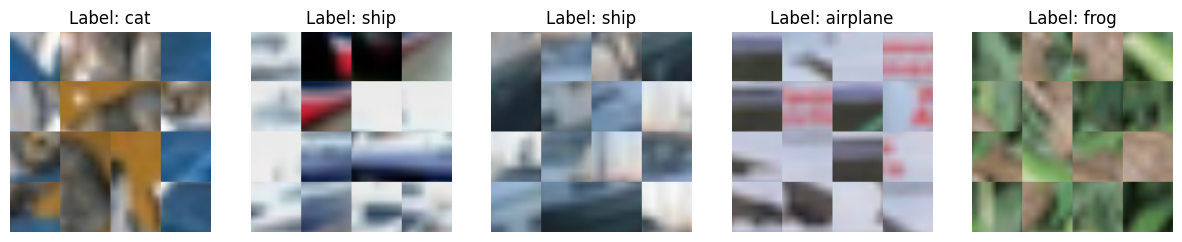

In [12]:
torch.manual_seed(42)

testloader = scramble_test_dl
dataiter = iter(testloader)
images, labels = next(dataiter)

# Create a plot for the 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    img = images[i].permute(1, 2, 0)    # Convert from CHW to HWC for displaying
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {classes[labels[i]]}')
    axes[i].axis('off')

plt.savefig('./task5_scramble.png')
plt.show()

# Global Style Transfer

In [16]:
import torch
import torchvision
from torch.utils.data import DataLoader

torch.manual_seed(42)

data_root = '../input/style-cifar/stylized_cifar10'
val_dataset = torchvision.datasets.ImageFolder(root=data_root, transform=TEST_TFMS)

style_test_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
style_loss, style_acc = eval_step(model, style_test_dl, criterion, device)

print(f'\n======================== Global Style Accuracy: {style_acc*100:.3f}% ========================')
print(f'======================== Normal Accuracy: {normal_acc*100:.3f}% ========================')

Evaluation: [16/16] Loss: 2.9614 Acc: 0.1406

======================== Global Style Accuracy: 14.062% ========================
======================== Normal Accuracy: 78.295% ========================


In [ ]:
torch.manual_seed(42)

testloader = style_test_dl
dataiter = iter(testloader)
images, labels = next(dataiter)

# Create a plot for the 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    img = images[i].permute(1, 2, 0)    # Convert from CHW to HWC for displaying
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {classes[labels[i]]}')
    axes[i].axis('off')

plt.savefig('./task5_style.png')
plt.show()